In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
import docx2txt
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lloyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Load dataset

In [5]:
df = pd.read_csv('data/Resume.csv')
df.drop(['ID', 'Resume_html'], axis=1, inplace=True)
df.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Resume_str  2484 non-null   object
 1   Category    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [7]:
df.columns

Index(['Resume_str', 'Category'], dtype='object')

In [8]:
print(f"Number of categories: {len(df['Category'].unique())}\nCategories:\n{df['Category'].unique()}")

Number of categories: 24
Categories:
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']


#### Pre-processing resumes

In [9]:
sample = df['Resume_str'][3]

In [10]:
sample

'         HR SPECIALIST       Summary    Dedicated, Driven, and Dynamic with over 20 years of customer service expertise. Motivated to maintain customer satisfaction and contribute to company success with an emphasis in personnel and process management. Solid team player with proven ability to establish rapport with clients.\xa0      Skills          Type 50 wpm and 10-Key by touch  Microsoft programs Word, Excel, Access, Outlook, PowerPoint  Personnel management  and Telephone inquiries specialist      Excellent customer service skills with call quality and customer satisfaction as primary focus.  Inbound and Outbound contact center experience  Excellent oral and written presentation and seasoned in conflict resolution\xa0            Experience      Hr Specialist     May 2007   to   Oct 2008      Company Name   －   City  ,   State     Accenture Peopleline Email Management Team.  Received inbound emails from clients as initial point of contact to answer questions related to HR policies,

In [11]:
def clean_resume(resume_str):
    # Remove extra whitespaces and newline characters
    cleaned_text = re.sub('\s+', ' ', resume_str).strip()

    # Remove URLs
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_text, flags=re.MULTILINE)

    # Remove @ mentions
    cleaned_text = re.sub(r'@\S+', '', cleaned_text)

    # Remove hashtags
    cleaned_text = re.sub(r'#\S+', '', cleaned_text)

    # Remove RT (retweets) and CC (carbon copies)
    cleaned_text = re.sub(r'\bRT\b|\bCC\b', '', cleaned_text)

    # Remove non-alphanumeric characters and special characters except spaces
    cleaned_text = re.sub('[^A-Za-z0-9\s]', '', cleaned_text)

    # Remove multiple consecutive spaces
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    return cleaned_text

In [12]:
cleaned_sample = clean_resume(sample)
print(cleaned_sample)

HR SPECIALIST Summary Dedicated Driven and Dynamic with over 20 years of customer service expertise Motivated to maintain customer satisfaction and contribute to company success with an emphasis in personnel and process management Solid team player with proven ability to establish rapport with clients Skills Type 50 wpm and 10Key by touch Microsoft programs Word Excel Access Outlook PowerPoint Personnel management and Telephone inquiries specialist Excellent customer service skills with call quality and customer satisfaction as primary focus Inbound and Outbound contact center experience Excellent oral and written presentation and seasoned in conflict resolution Experience Hr Specialist May 2007 to Oct 2008 Company Name City State Accenture Peopleline Email Management Team Received inbound emails from clients as initial point of contact to answer questions related to HR policies practices or to resolve issues Helped the client by answering their inquiry resolving their issue or routing

In [13]:
df['Resume_str'] = df['Resume_str'].apply(lambda x: clean_resume(x))

In [14]:
def get_most_frequent_words(resumes, num_words=10, common_words=None):
    stop_words = set(stopwords.words('english'))
    if common_words is not None:
        stop_words.update(common_words)
    all_words = ' '.join(resumes).split()
    filtered_words = [word for word in all_words if word not in stop_words]
    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(num_words)
    return most_common_words

In [15]:
most_common_words = get_most_frequent_words(df['Resume_str'], num_words=50)
print("Most Common Words:")
print(most_common_words)

Most Common Words:
[('State', 15328), ('City', 14942), ('Company', 11889), ('Name', 11651), ('management', 6920), ('customer', 5923), ('sales', 5552), ('new', 5463), ('Management', 4997), ('team', 4577), ('business', 4376), ('I', 4349), ('service', 4257), ('skills', 4161), ('including', 3994), ('development', 3791), ('training', 3751), ('Skills', 3487), ('customers', 3448), ('work', 3416), ('staff', 3365), ('Education', 3324), ('support', 3194), ('clients', 3132), ('Manager', 3120), ('University', 3110), ('Business', 3093), ('financial', 3060), ('project', 2977), ('Experience', 2872), ('reports', 2838), ('data', 2816), ('Microsoft', 2788), ('marketing', 2784), ('company', 2767), ('experience', 2718), ('process', 2694), ('system', 2628), ('information', 2610), ('systems', 2443), ('quality', 2434), ('client', 2434), ('Office', 2393), ('product', 2371), ('procedures', 2366), ('Developed', 2352), ('Sales', 2347), ('Managed', 2339), ('analysis', 2329), ('projects', 2329)]


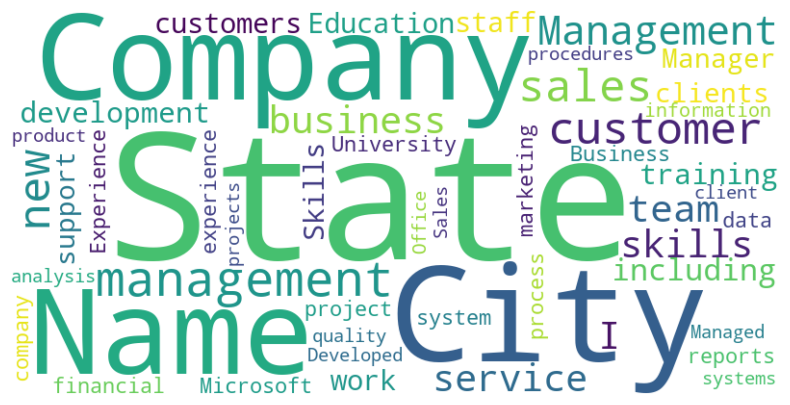

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
df_sorted = df.sort_values(by='Category')
# join clean resumes of all categories
grouped_resumes = df_sorted.groupby('Category')['Resume_str'].apply(lambda x: ' '.join(x)).reset_index()

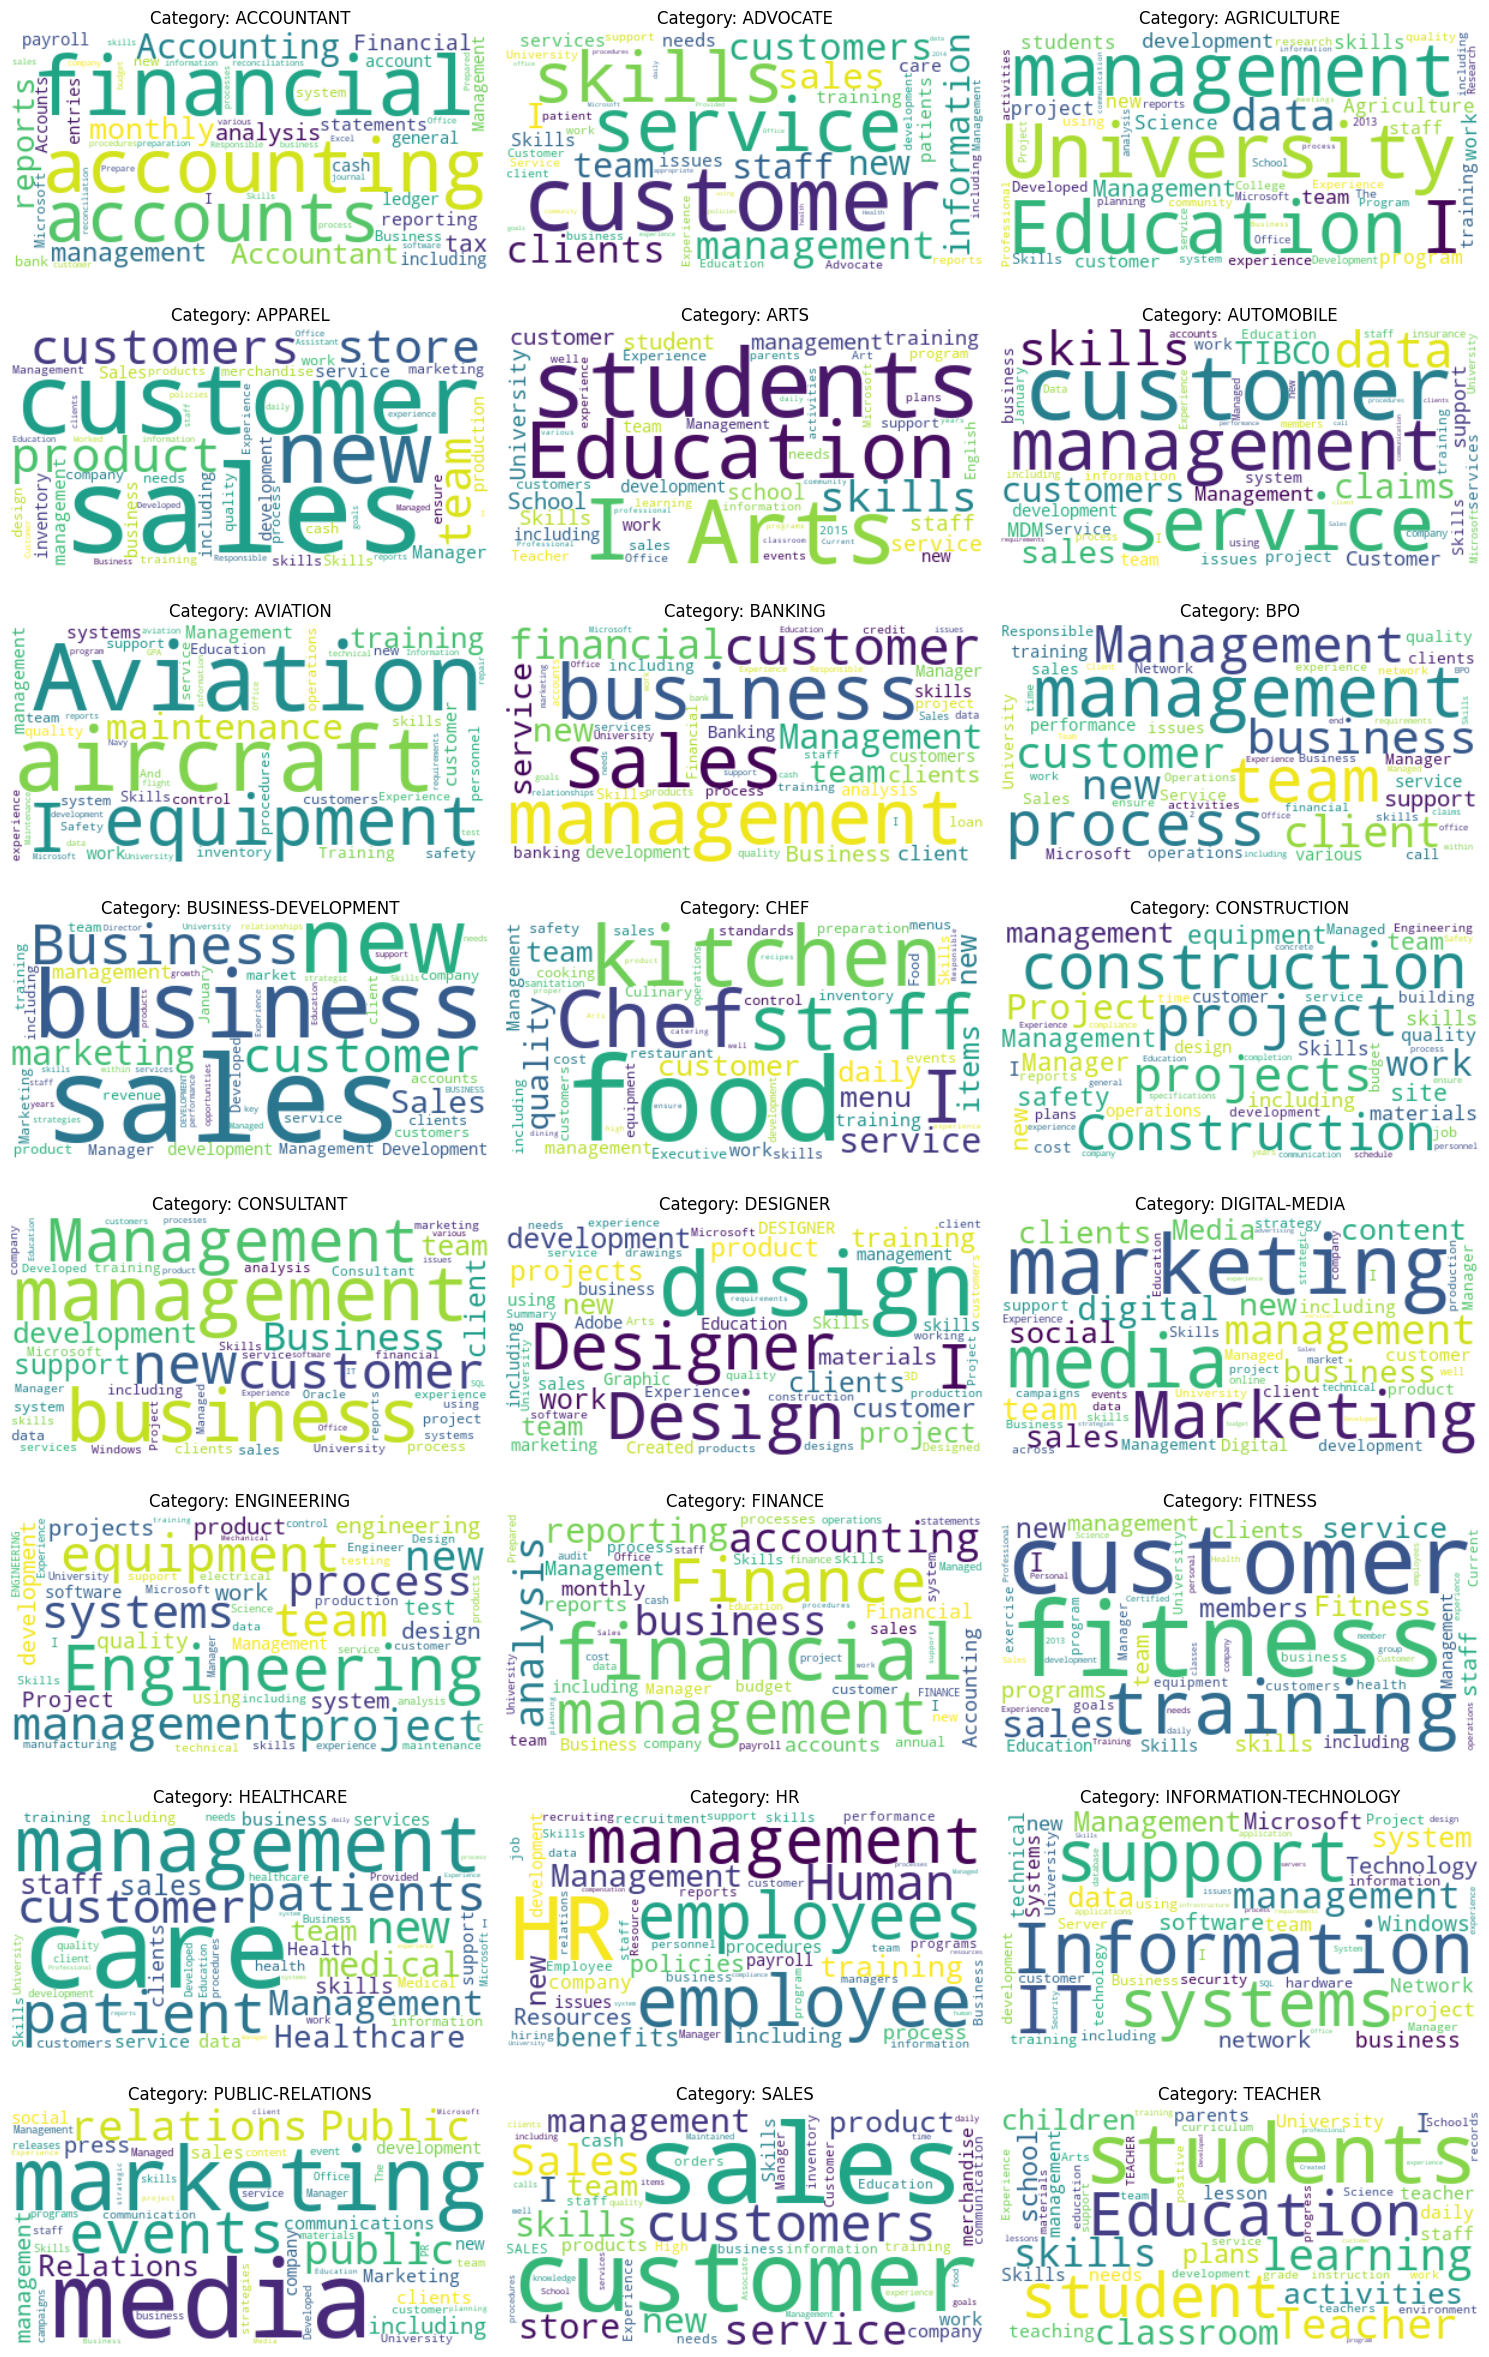

In [18]:
num_categories = len(grouped_resumes)
num_cols = 3  # You can change the number of columns based on your preference
num_rows = (num_categories // num_cols)  # Ceiling division to calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Generate word clouds for each category and plot in subplots
for index, row in grouped_resumes.iterrows():
    category_resumes = row['Resume_str']
    category = row['Category']

    # Get most common words for the category
    most_common_words = get_most_frequent_words([category_resumes], num_words=50, common_words=['State', 'Company', 'City', 'Name'])

    # Create word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(most_common_words))

    # Plot word cloud in the corresponding subplot
    ax = axes[index // num_cols, index % num_cols]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Category: {category}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

In [20]:
# Create a mapping from encoded labels to category names
label_to_category = dict(zip(df['Category_encoded'], df['Category']))

# Print the mapping
print("Label to Category Mapping:")
print(label_to_category)

Label to Category Mapping:
{19: 'HR', 13: 'DESIGNER', 20: 'INFORMATION-TECHNOLOGY', 23: 'TEACHER', 1: 'ADVOCATE', 9: 'BUSINESS-DEVELOPMENT', 18: 'HEALTHCARE', 17: 'FITNESS', 2: 'AGRICULTURE', 8: 'BPO', 22: 'SALES', 12: 'CONSULTANT', 14: 'DIGITAL-MEDIA', 5: 'AUTOMOBILE', 10: 'CHEF', 16: 'FINANCE', 3: 'APPAREL', 15: 'ENGINEERING', 0: 'ACCOUNTANT', 11: 'CONSTRUCTION', 21: 'PUBLIC-RELATIONS', 7: 'BANKING', 4: 'ARTS', 6: 'AVIATION'}


#### Vectorization of resumes with sentence transformers

In [21]:
# model_name = 'all-distilroberta-v1'
# model = SentenceTransformer(model_name)

# # Obtain embeddings for cleaned resumes
# embeddings = model.encode(df['Resume_str'], show_progress_bar=True)

In [22]:
tfidf_model = TfidfVectorizer(stop_words='english')
embeddings = tfidf_model.fit_transform(df['Resume_str'])

In [23]:
embeddings.shape

(2484, 53746)

In [24]:
pca = PCA(n_components=1000)
lower_embed = pca.fit_transform(embeddings.toarray())
pca.explained_variance_ratio_.sum()

0.7247808388577034

In [25]:
X_train, X_test, y_train, y_test = train_test_split(lower_embed, df['Category_encoded'], test_size=0.2, random_state=42, stratify=df['Category_encoded'])

In [26]:
print(f"Shape X_Train: {X_train.shape}\nShape of X_test: {X_test.shape}\nShape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape X_Train: (1987, 1000)
Shape of X_test: (497, 1000)
Shape of y_train: (1987,)
Shape of y_test: (497,)


In [27]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [29]:
accuracy_score(y_test, y_pred)

0.5251509054325956

In [30]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_to_category.values()))

Classification Report:
                        precision    recall  f1-score   support

                    HR       0.59      0.83      0.69        24
              DESIGNER       0.50      0.29      0.37        24
INFORMATION-TECHNOLOGY       1.00      0.15      0.27        13
               TEACHER       0.33      0.16      0.21        19
              ADVOCATE       0.44      0.33      0.38        21
  BUSINESS-DEVELOPMENT       0.67      0.29      0.40         7
            HEALTHCARE       0.90      0.38      0.53        24
               FITNESS       0.67      0.26      0.38        23
           AGRICULTURE       0.00      0.00      0.00         4
                   BPO       0.31      0.75      0.43        24
                 SALES       0.84      0.67      0.74        24
            CONSULTANT       0.62      0.68      0.65        22
         DIGITAL-MEDIA       0.33      0.04      0.08        23
            AUTOMOBILE       0.85      0.52      0.65        21
                

c:\Users\lloyd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lloyd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lloyd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [33]:
import pickle
import joblib
filename = 'resume_screener.pkl'
joblib.dump(clf, filename)

['resume_screener.pkl']